<a href="https://colab.research.google.com/github/skarlant001/Geoscripting/blob/master/test04_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install googledrivedownloader
!pip install split-folders

In [ ]:
import os
import pdb
import copy
import glob 
import time
import torch
import shutil
import zipfile
import sklearn
import torchvision
import splitfolders
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
from csv import reader
from natsort import natsorted
from google.colab import drive
from skimage import io, transform
from sklearn.metrics import f1_score
from torch.optim import lr_scheduler
from __future__ import print_function, division
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import average_precision_score
from torchvision import datasets, models, transforms, utils
from google_drive_downloader import GoogleDriveDownloader as gdd
print(torch.__version__)

1.8.1+cu101


In [ ]:
!rm -rf all_images/
!rm -rf Images
!rm -rf sample_data
!rm -rf test/
!rm -rf train/
!rm -rf val/

In [ ]:
drive.mount('/content/drive/')
with zipfile.ZipFile('/content/drive/My Drive/imageLD.zip', 'r') as zip_ref:
    zip_ref.extractall('Images')

images_path = "Images/"
path1 = "/content/"

Mounted at /content/drive/


In [ ]:
destination_path = "./Images/"
output_path = "./Images/"
splitfolders.ratio(destination_path, output=output_path, seed=1337, ratio=(.8, .1, .1))

Copying files: 8571 files [00:45, 187.56 files/s]


In [ ]:
# Getting the images out of the subfolders and moving them into the train, test and val folders respectively
destination_path1 = "./train/"
pattern1 = "./Images/train/"
for img in glob.glob(pattern1):
    shutil.move(img, destination_path1)

In [ ]:
destination_path2 = "./test/"
pattern2 = "./Images/test/"
for img in glob.glob(pattern2):
    shutil.move(img, destination_path2)

In [ ]:
destination_path3 = "./val/"
pattern3 = "./Images/val/"
for img in glob.glob(pattern3):
    shutil.move(img, destination_path3)

In [ ]:
## Get the attribute names in an array
attributes = pd.read_fwf('/content/drive/My Drive/attributes.txt', header=None)
attributes = np.asarray(attributes)
## Get the annotations in an array
scoress = pd.read_csv('/content/drive/My Drive/annotat.tsv', sep="\t")
n = 40 # the total number of transient attributes
img_names = scoress.iloc[:,0]
image_name = scoress.iloc[n, 0]
att_scoress = scoress.iloc[n, 1:]
att_scoress = np.asarray(att_scoress)
att_scoress = att_scoress.astype('float')
att_scoress = np.round(att_scoress, decimals=4)

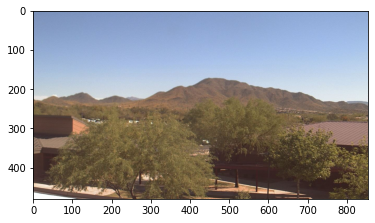

0.8655 ['daylight']
1.0 ['sunny']
0.5798 ['spring']
1.0 ['summer']
0.8619 ['rugged']
1.0 ['dry']
0.6434 ['lush']


In [ ]:
# show an image and its scores
def show_scores(image, img_scores, labels):
   """Show image with scores"""
   plt.imshow(image)  
   plt.pause(0.001)  # pause a bit so that plots are updated
   for s, a in zip(img_scores, labels):
    if s > 0.57:
      print(s, a)  
   
plt.figure()
show_scores(io.imread(os.path.join("./Images/", image_name)),
               att_scoress, attributes)
plt.show()

In [ ]:
class AnnotationDataset(Dataset):

    def __init__(self, csv_file, txt_file, split="train", transform=None):
         
        self.scores = pd.read_csv(csv_file, sep="\t", header=None)
        self.images = glob.glob(f'./{split}/*/*.jpg') 
        self.labels = self.scores.set_index(0).agg(list, axis=1).to_dict()

        self.attributes = pd.read_fwf(txt_file, header=None)
        self.transform = transform

    def __len__(self):
        return len(self.images)
        

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        #import pdb;pdb.set_trace()#########
        img = self.images[idx]

        image = Image.open(img)
        images = np.asarray(image, dtype="float32" )
        path = os.path.normpath(img).split(os.path.sep)
        img_path = os.path.join(*path[-2:])
        att_sc = self.labels.get(img_path) #split text to take out train/*
        att_sc = np.asarray(att_sc)
        att_sc = att_sc.astype('float')
        att_sc = np.round(att_sc, decimals=4)
        if self.transform is not None:
            image = self.transform(image)  
        
        sample = (image, att_sc)
        return sample
        

In [ ]:
train_dataset = AnnotationDataset(csv_file= '/content/drive/My Drive/annotat.tsv', 
                                  txt_file='/content/drive/My Drive/attributes.txt',
                                  split = 'train')

val_dataset = AnnotationDataset(csv_file= '/content/drive/My Drive/annotat.tsv', 
                                  txt_file='/content/drive/My Drive/attributes.txt',
                                  split = 'val')

test_dataset = AnnotationDataset(csv_file= '/content/drive/My Drive/annotat.tsv', 
                                  txt_file='/content/drive/My Drive/attributes.txt',
                                  split = 'test')

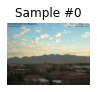

0.6394 ['daylight']
1.0 ['dawndusk']
0.8344 ['rugged']


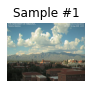

0.6394 ['daylight']
0.6375 ['clouds']
0.5715 ['summer']
0.9327 ['rugged']
0.6972 ['dry']
0.6065 ['boring']


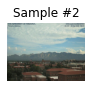

0.6256 ['clouds']
0.9327 ['rugged']
0.723 ['boring']


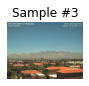

1.0 ['daylight']
0.8927 ['sunny']
0.6484 ['warm']
0.5824 ['summer']
0.6534 ['autumn']
0.8535 ['colorful']
0.9769 ['rugged']
0.7902 ['midday']
1.0 ['bright']
0.6246 ['dry']
0.7664 ['lush']


In [ ]:
fig = plt.figure()
# for i in range(len(image_dataset)):
for i, batch in enumerate(train_dataset):
    image, scores = batch
    #import pdb;pdb.set_trace()
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    #ax.set_title(img_name)
    ax.axis('off')
    show_scores(image, scores, attributes)

    if i == 3:
        plt.show()
        break

In [ ]:
txt='/content/drive/My Drive/attributes.txt'
csv= '/content/drive/My Drive/annotat.tsv'
batch_size = 20

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()])
}

print("Initializing Datasets and Dataloaders...")

Initializing Datasets and Dataloaders...


In [ ]:
image_datasets = {x: AnnotationDataset(csv, txt, split=x, 
                                       transform=data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], shuffle=True, batch_size=batch_size) for x in ['train', 'val']}#, batch_size=20
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Setting up the CNN
model_conv=torchvision.models.resnet50(pretrained=True)
model_conv.fc = nn.Sequential(nn.Linear(2048, 40), nn.Sigmoid())
model_conv = model_conv.to(device)
# Loss Function
criterion = nn.BCELoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.Adam([
                {'params': list(model_conv.parameters())[:-1]},
                {'params': list(model_conv.parameters())[-1], 'lr': 5e-3}
            ], lr=1e-4, weight_decay=0)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=2, gamma=0.7)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
import pdb

def train_model(model, dataloaders, criterion, optimizer, scheduler, batch_size=5, num_epochs=10):#
    since = time.time()
    val_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    #pdb.set_trace()
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode


            running_loss = 0.0
            running_corrects = 0
            average_precis_train = 0.001
            average_precis_train_per_class = 0.001
            loss_values = []
            # arrays to store preds and gr truth of each iteration
            gr_truth_array = np.array([]) #convet to int dtype
            preds_array = np.array([])
            gr_truth_array = gr_truth_array.astype(int)
            preds_array = preds_array.astype(int) 
            average_precision_array = np.array([]).astype(float)
            param = np.array([])

            # Iterate over data.
            #for inputs in dataloaders[phase]:
            print('Iterating over data:')
            for batch_idx, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device).float()
                gt_data = labels
                gt_data = gt_data.to(device)
                gt_data = gt_data.cpu().data.numpy()
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                if phase == 'train':
                  with torch.set_grad_enabled(phase == 'train'):
                      outputs = model(inputs)
                      outputs = outputs.cpu()
                      preds = outputs.cpu().data.numpy()
                      preds = np.round(preds) #set a condition for binary
                      preds_int = preds.astype(int)
                      gt_data_np = np.round(gt_data)
                      gt_data_int = gt_data_np.astype(int)
                      gt_data = torch.from_numpy(gt_data_np)
                      loss = criterion(outputs, gt_data)
                      gr_truth_array = np.append(gr_truth_array, gt_data_int)
                      preds_array = np.append(preds_array ,preds_int)
                      s = sum([torch.sum(p) for p in model.parameters() if p.requires_grad])
                      s = s.cpu().data.numpy()
                    # backward + optimize only if in training phase
                      if phase == 'train':
                          loss.backward()
                          optimizer.step()
                # statistics
                  gr_truth_array = np.reshape(gr_truth_array, (-1, 40))
                  preds_array = np.reshape(preds_array, (-1, 40))
                  running_loss += loss.item() * inputs.size(0)
                  running_corrects += f1_score(gt_data, preds, average="samples")

                
            if phase == 'train':
                scheduler.step()
                average_precis_train += average_precision_score(gr_truth_array, preds_array, average= "macro")
                average_precis_train_per_class += average_precision_score(gr_truth_array, preds_array, average=None)
                average_precision_array = np.append(average_precision_array, average_precis_train_per_class)
                #Match accuracies with their attributes
                av_precis_array = [j for i in zip(average_precision_array, attributes) for j in i]
                av_precis_array = np.array(av_precis_array)
                av_precis_array = np.resize(av_precis_array,(40,2))
                print("Average precision Training:", average_precis_train)      
                print("Average precision per Class Training:", av_precis_array)
                print("Model Parameters:", s)

            #pdb.set_trace()   
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset) #running_corrects.float()
            epoch_acc = np.round(epoch_acc, decimals=4)
            
 

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))
            print("Acc:", epoch_acc)
 
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))


    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:
model_ft, hist = train_model(model_conv, dataloaders, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
Iterating over data:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Average precision Training: 0.3962722295010007
Average precision per Class Training: [[0.4061709179370252 array(['dirty'], dtype=object)]
 [0.8367559576181897 array(['daylight'], dtype=object)]
 [0.4395364615416266 array(['night'], dtype=object)]
 [0.28249829998295284 array(['sunrisesunset'], dtype=object)]
 [0.36582609784120074 array(['dawndusk'], dtype=object)]
 [0.5661179782067077 array(['sunny'], dtype=object)]
 [0.6542750428671217 array(['clouds'], dtype=object)]
 [0.3356136170732561 array(['fog'], dtype=object)]
 [0.2431461378346673 array(['storm'], dtype=object)]
 [0.6050585134987847 array(['snow'], dtype=object)]
 [0.41153377129488566 array(['warm'], dtype=object)]
 [0.6325207963237608 array(['cold'], dtype=object)]
 [0.4282954302714488 array(['busy'], dtype=object)]
 [0.4474084379453487 array(['beautiful'], dtype=object)]
 [0.015643432420559378 array(['flowers'], dtype=object)]
 [0.2305698807065123 array(['spring'], dtype=object)]
 [0.3771436247054315 array(['summer'], dtype=o

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Average precision Training: 0.4639227021871551
Average precision per Class Training: [[0.4959996907268993 array(['dirty'], dtype=object)]
 [0.8712075547003726 array(['daylight'], dtype=object)]
 [0.5568586048908071 array(['night'], dtype=object)]
 [0.4113322125944813 array(['sunrisesunset'], dtype=object)]
 [0.4309297831998404 array(['dawndusk'], dtype=object)]
 [0.6064993787562464 array(['sunny'], dtype=object)]
 [0.6968080076203792 array(['clouds'], dtype=object)]
 [0.4307925254891868 array(['fog'], dtype=object)]
 [0.3123739604753128 array(['storm'], dtype=object)]
 [0.6846152793133055 array(['snow'], dtype=object)]
 [0.4935996228491696 array(['warm'], dtype=object)]
 [0.6929907987802157 array(['cold'], dtype=object)]
 [0.531990168377499 array(['busy'], dtype=object)]
 [0.5178965982215249 array(['beautiful'], dtype=object)]
 [0.015643432420559378 array(['flowers'], dtype=object)]
 [0.27968009010608735 array(['spring'], dtype=object)]
 [0.43623529190449695 array(['summer'], dtype=obj

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Average precision Training: 0.5119509039910305
Average precision per Class Training: [[0.5847924049008361 array(['dirty'], dtype=object)]
 [0.8841651619634179 array(['daylight'], dtype=object)]
 [0.6007301476512945 array(['night'], dtype=object)]
 [0.45468575659853816 array(['sunrisesunset'], dtype=object)]
 [0.4868649817604507 array(['dawndusk'], dtype=object)]
 [0.6303723166296541 array(['sunny'], dtype=object)]
 [0.7222254522468823 array(['clouds'], dtype=object)]
 [0.4805582304087449 array(['fog'], dtype=object)]
 [0.37385053357675563 array(['storm'], dtype=object)]
 [0.7532376763358005 array(['snow'], dtype=object)]
 [0.5339965842792195 array(['warm'], dtype=object)]
 [0.7521064011122265 array(['cold'], dtype=object)]
 [0.5831845518215532 array(['busy'], dtype=object)]
 [0.5739071753155994 array(['beautiful'], dtype=object)]
 [0.015643432420559378 array(['flowers'], dtype=object)]
 [0.3226236562719919 array(['spring'], dtype=object)]
 [0.4857648432466183 array(['summer'], dtype=ob

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Average precision Training: 0.5346582890200179
Average precision per Class Training: [[0.6137943064140426 array(['dirty'], dtype=object)]
 [0.8906833005699561 array(['daylight'], dtype=object)]
 [0.6022922062039281 array(['night'], dtype=object)]
 [0.4901858623441651 array(['sunrisesunset'], dtype=object)]
 [0.5093597082216432 array(['dawndusk'], dtype=object)]
 [0.6493030163243765 array(['sunny'], dtype=object)]
 [0.7382448747861926 array(['clouds'], dtype=object)]
 [0.525328298920247 array(['fog'], dtype=object)]
 [0.38874599358617257 array(['storm'], dtype=object)]
 [0.7849930336497207 array(['snow'], dtype=object)]
 [0.5423493242777391 array(['warm'], dtype=object)]
 [0.7744970270411952 array(['cold'], dtype=object)]
 [0.6227848735866213 array(['busy'], dtype=object)]
 [0.598182156579837 array(['beautiful'], dtype=object)]
 [0.015643432420559378 array(['flowers'], dtype=object)]
 [0.3551839174609232 array(['spring'], dtype=object)]
 [0.5092056334519071 array(['summer'], dtype=objec

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Average precision Training: 0.5585215043486584
Average precision per Class Training: [[0.6461408810518019 array(['dirty'], dtype=object)]
 [0.8970220290738881 array(['daylight'], dtype=object)]
 [0.6468083736086818 array(['night'], dtype=object)]
 [0.5077626327224973 array(['sunrisesunset'], dtype=object)]
 [0.5322591688065522 array(['dawndusk'], dtype=object)]
 [0.6776448477181204 array(['sunny'], dtype=object)]
 [0.7440765998309842 array(['clouds'], dtype=object)]
 [0.5243569313022435 array(['fog'], dtype=object)]
 [0.4101238117935866 array(['storm'], dtype=object)]
 [0.8053368501488017 array(['snow'], dtype=object)]
 [0.5843426081772263 array(['warm'], dtype=object)]
 [0.78490160455963 array(['cold'], dtype=object)]
 [0.648680349734628 array(['busy'], dtype=object)]
 [0.6081946865922709 array(['beautiful'], dtype=object)]
 [0.015643432420559378 array(['flowers'], dtype=object)]
 [0.39237496484223366 array(['spring'], dtype=object)]
 [0.5498053972093787 array(['summer'], dtype=object

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Average precision Training: 0.5727748675160041
Average precision per Class Training: [[0.6586732497994706 array(['dirty'], dtype=object)]
 [0.9069599794571253 array(['daylight'], dtype=object)]
 [0.6211167474842727 array(['night'], dtype=object)]
 [0.5106965262534934 array(['sunrisesunset'], dtype=object)]
 [0.5174682468477696 array(['dawndusk'], dtype=object)]
 [0.6729904684189162 array(['sunny'], dtype=object)]
 [0.7473627308526475 array(['clouds'], dtype=object)]
 [0.5722017762314735 array(['fog'], dtype=object)]
 [0.42066909440095396 array(['storm'], dtype=object)]
 [0.8086588952703146 array(['snow'], dtype=object)]
 [0.592324551840099 array(['warm'], dtype=object)]
 [0.7997046542674506 array(['cold'], dtype=object)]
 [0.654428682145028 array(['busy'], dtype=object)]
 [0.6253717188780467 array(['beautiful'], dtype=object)]
 [0.02335056377214819 array(['flowers'], dtype=object)]
 [0.4179390893357404 array(['spring'], dtype=object)]
 [0.5669807031748834 array(['summer'], dtype=object

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Average precision Training: 0.5933621338320082
Average precision per Class Training: [[0.679777240975155 array(['dirty'], dtype=object)]
 [0.9089541152933074 array(['daylight'], dtype=object)]
 [0.6680912508389298 array(['night'], dtype=object)]
 [0.5495556212603441 array(['sunrisesunset'], dtype=object)]
 [0.5486508132102481 array(['dawndusk'], dtype=object)]
 [0.6816964600888686 array(['sunny'], dtype=object)]
 [0.7536111104628059 array(['clouds'], dtype=object)]
 [0.5872075031288938 array(['fog'], dtype=object)]
 [0.43941618190013815 array(['storm'], dtype=object)]
 [0.8333823646476011 array(['snow'], dtype=object)]
 [0.6259556949302596 array(['warm'], dtype=object)]
 [0.8040159466072665 array(['cold'], dtype=object)]
 [0.6632386382804806 array(['busy'], dtype=object)]
 [0.6418997039894637 array(['beautiful'], dtype=object)]
 [0.03791483798087986 array(['flowers'], dtype=object)]
 [0.44130602869265306 array(['spring'], dtype=object)]
 [0.569156688861844 array(['summer'], dtype=objec

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Average precision Training: 0.6055913319126017
Average precision per Class Training: [[0.6892560691613995 array(['dirty'], dtype=object)]
 [0.9117644911059515 array(['daylight'], dtype=object)]
 [0.6827855712812301 array(['night'], dtype=object)]
 [0.5443116645060172 array(['sunrisesunset'], dtype=object)]
 [0.5771832830260518 array(['dawndusk'], dtype=object)]
 [0.6957561175820135 array(['sunny'], dtype=object)]
 [0.76605041018962 array(['clouds'], dtype=object)]
 [0.6213812474318242 array(['fog'], dtype=object)]
 [0.4676093143094154 array(['storm'], dtype=object)]
 [0.8365390349450129 array(['snow'], dtype=object)]
 [0.62531996564554 array(['warm'], dtype=object)]
 [0.8141623064395312 array(['cold'], dtype=object)]
 [0.6919697227290907 array(['busy'], dtype=object)]
 [0.6613480329889877 array(['beautiful'], dtype=object)]
 [0.07476482647532581 array(['flowers'], dtype=object)]
 [0.44432532555693205 array(['spring'], dtype=object)]
 [0.5768067977573498 array(['summer'], dtype=object)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Average precision Training: 0.6169749682435695
Average precision per Class Training: [[0.7030544412584954 array(['dirty'], dtype=object)]
 [0.9166733341155032 array(['daylight'], dtype=object)]
 [0.6849612741179139 array(['night'], dtype=object)]
 [0.5591438592878417 array(['sunrisesunset'], dtype=object)]
 [0.5854694959093715 array(['dawndusk'], dtype=object)]
 [0.7014519799394929 array(['sunny'], dtype=object)]
 [0.7758924312932828 array(['clouds'], dtype=object)]
 [0.5820888105897882 array(['fog'], dtype=object)]
 [0.47009940520436744 array(['storm'], dtype=object)]
 [0.8524316487067453 array(['snow'], dtype=object)]
 [0.6407347619933944 array(['warm'], dtype=object)]
 [0.8201707927551222 array(['cold'], dtype=object)]
 [0.6915598318858066 array(['busy'], dtype=object)]
 [0.6613182544471303 array(['beautiful'], dtype=object)]
 [0.10432552350270903 array(['flowers'], dtype=object)]
 [0.45861964534771704 array(['spring'], dtype=object)]
 [0.6067393526653758 array(['summer'], dtype=obj

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Average precision Training: 0.624921358422073
Average precision per Class Training: [[0.7043623101553624 array(['dirty'], dtype=object)]
 [0.9133439396882599 array(['daylight'], dtype=object)]
 [0.7171493136603863 array(['night'], dtype=object)]
 [0.583596369266197 array(['sunrisesunset'], dtype=object)]
 [0.5994425975665068 array(['dawndusk'], dtype=object)]
 [0.7051223290719986 array(['sunny'], dtype=object)]
 [0.772256038392606 array(['clouds'], dtype=object)]
 [0.5966799174706159 array(['fog'], dtype=object)]
 [0.4860254543203082 array(['storm'], dtype=object)]
 [0.8499027985301001 array(['snow'], dtype=object)]
 [0.6447756620089637 array(['warm'], dtype=object)]
 [0.8246300837899561 array(['cold'], dtype=object)]
 [0.7003599541401259 array(['busy'], dtype=object)]
 [0.6734743930710895 array(['beautiful'], dtype=object)]
 [0.08182552350270904 array(['flowers'], dtype=object)]
 [0.478670153554381 array(['spring'], dtype=object)]
 [0.6050040581145881 array(['summer'], dtype=object)]


In [ ]:
import pdb

def eval_model(model, dataloaders, criterion, optimizer, scheduler, batch_size=5, num_epochs=10):#
    since = time.time()
    val_acc_history = []
    best_acc = 0.0
    #pdb.set_trace()
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            average_precis = 0.001
            average_precis_per_class = 0.001
            loss_values = []
            # arrays to store preds and gr truth of each iteration
            gr_truth_val = np.array([]) #convet to int dtype
            preds_val = np.array([])
            gr_truth_val = gr_truth_val.astype(int)
            preds_val = preds_val.astype(int) 
            average_precision_array_val = np.array([]).astype(float)
            param = np.array([])

            # Iterate over data.
            #for inputs in dataloaders[phase]:
            print('Iterating over data:')
            for batch_idx, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device).float()
                gt_data = labels
                gt_data = gt_data.to(device)
                gt_data = gt_data.cpu().data.numpy()
                average_precision_array = []
                # zero the parameter gradients
                optimizer.zero_grad()
                # track history if only in train
                #pdb.set_trace()
                if phase == 'val':  
                  #pdb.set_trace()
                  with torch.no_grad():
                      val_outputs = model(inputs)
                      val_outputs = val_outputs.cpu()
                      val_preds = val_outputs.cpu().data.numpy()
                      val_preds = np.round(val_preds) #set a condition for binary
                      val_preds = val_preds.astype(int)
                      val_gtdata_np = np.round(gt_data)
                      val_gtdata_int = val_gtdata_np.astype(int)
                      val_gtdata = torch.from_numpy(val_gtdata_np)
                      loss = criterion(val_outputs, val_gtdata)
                      gr_truth_val = np.append(gr_truth_val, val_gtdata_int)
                      preds_val = np.append(preds_val ,val_preds)
                      s = sum([torch.sum(p) for p in model.parameters() if p.requires_grad])
                      s = s.cpu().data.numpy()
                      param = np.append(param, s)
                  # statistics
                  running_loss += loss.item() * inputs.size(0)
                  running_corrects += f1_score(val_gtdata, val_preds, average='samples')
                  gr_truth_val = np.reshape(gr_truth_val, (-1, 40))
                  preds_val = np.reshape(preds_val, (-1, 40))
                       
                

            #pdb.set_trace()   
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset) #running_corrects.float()
            epoch_acc = np.round(epoch_acc, decimals=4)
            
            if phase == 'val':
              scheduler.step()
              epoch_loss = running_loss / len(dataloaders[phase].dataset)
              epoch_acc = running_corrects / len(dataloaders[phase].dataset) #running_corrects.float()
              epoch_acc = np.round(epoch_acc, decimals=4)
              average_precis += average_precision_score(gr_truth_val, preds_val, average="macro")
              average_precis_per_class += average_precision_score(gr_truth_val, preds_val, average=None)
              #Match accuracies with their attributes
              average_precision_array_val = np.append(average_precision_array_val, average_precis_per_class)
              av_precis_array_val = [j for i in zip(average_precision_array_val, attributes) for j in i]
              av_precis_array_val = np.array(av_precis_array_val)
              av_precis_array_val = np.resize(av_precis_array_val,(40,2))
              print("Average precision Validation:", average_precis)
              print("Average precision per Class Validation:", av_precis_array_val)
              print("Model Parameters:", param)


            print('{} Loss: {:.4f}'.format(phase, epoch_loss))
            print("Acc:", epoch_acc)

            #Plot an image wih the predictions by the end of each epoch
            if phase == 'val':
              #pdb.set_trace()
              for jp in range(inputs.size()[0]):
                  ax = plt.subplot(1, 4, jp + 1)
                  plt.figure(figsize=[5, 4])
                  ax.axis('off')
                  ax.set_title('Sample #{}'.format(jp))
                  img = inputs.cpu().data[jp].numpy().transpose((1, 2, 0))
                  for value in val_outputs:
                    show_scores(img, value, attributes)
                    break      

                  #if jp == 1:
                  plt.show()
                  break 
        
    print()  
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return model, val_acc_history

Epoch 0/9
----------
Iterating over data:
train Loss: 0.0000
Acc: 0.0
Iterating over data:
Average precision Validation: 0.24645301031584915
Average precision per Class Validation: [[0.25313154689403167 array(['dirty'], dtype=object)]
 [0.6879382809888184 array(['daylight'], dtype=object)]
 [0.11695869767705423 array(['night'], dtype=object)]
 [0.13667352944728126 array(['sunrisesunset'], dtype=object)]
 [0.1337195406750754 array(['dawndusk'], dtype=object)]
 [0.3246328676745309 array(['sunny'], dtype=object)]
 [0.46572019464720193 array(['clouds'], dtype=object)]
 [0.15343420356667611 array(['fog'], dtype=object)]
 [0.11738280616382807 array(['storm'], dtype=object)]
 [0.27450506712103295 array(['snow'], dtype=object)]
 [0.22878996320400802 array(['warm'], dtype=object)]
 [0.38024158246190054 array(['cold'], dtype=object)]
 [0.29863569593196443 array(['busy'], dtype=object)]
 [0.3228452775934528 array(['beautiful'], dtype=object)]
 [0.01924817518248175 array(['flowers'], dtype=object)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


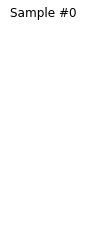

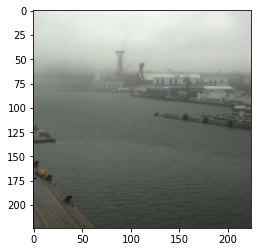

tensor(0.6360) ['dirty']
tensor(0.6035) ['sunrisesunset']
tensor(0.6546) ['clouds']
tensor(0.5778) ['midday']
tensor(0.6014) ['dark']
tensor(0.5833) ['dry']
tensor(0.5903) ['soothing']
tensor(0.6203) ['boring']
Epoch 1/9
----------
Iterating over data:
train Loss: 0.0000
Acc: 0.0
Iterating over data:
Average precision Validation: 0.24645301031584915
Average precision per Class Validation: [[0.25313154689403167 array(['dirty'], dtype=object)]
 [0.6879382809888184 array(['daylight'], dtype=object)]
 [0.11695869767705423 array(['night'], dtype=object)]
 [0.13667352944728126 array(['sunrisesunset'], dtype=object)]
 [0.1337195406750754 array(['dawndusk'], dtype=object)]
 [0.3246328676745309 array(['sunny'], dtype=object)]
 [0.46572019464720193 array(['clouds'], dtype=object)]
 [0.15343420356667611 array(['fog'], dtype=object)]
 [0.11738280616382807 array(['storm'], dtype=object)]
 [0.27450506712103295 array(['snow'], dtype=object)]
 [0.22878996320400802 array(['warm'], dtype=object)]
 [0.38

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


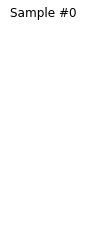

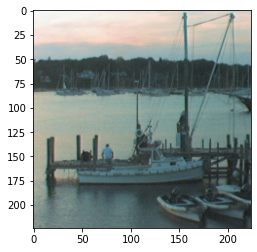

tensor(0.5991) ['dirty']
tensor(0.5735) ['daylight']
tensor(0.6215) ['sunrisesunset']
tensor(0.6807) ['clouds']
tensor(0.5971) ['snow']
tensor(0.6089) ['busy']
tensor(0.6060) ['rugged']
tensor(0.6427) ['midday']
tensor(0.5909) ['ice']
tensor(0.6631) ['soothing']
tensor(0.5742) ['stressful']
tensor(0.6219) ['sentimental']
Epoch 2/9
----------
Iterating over data:


TypeError: ignored

In [ ]:
model_eval, hist = eval_model(model_ft, dataloaders, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)